# Hybrid model with added validation split, early stopping and visuals (loss curve + prediction scatter + rating distribution)

In [5]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

2025-04-03 18:34:11.350853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# feature extraction 

data_dir = "/Users/andresaccone/Downloads/Data/genres_original"
genres = ["blues", "classical", "country", "disco", "hiphop",
          "jazz", "metal", "pop", "reggae", "rock"]

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        tempo = librosa.beat.tempo(y=y, sr=sr)[0]
        rms = np.mean(librosa.feature.rms(y=y))
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        return np.array([tempo, rms, spec_centroid])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.array([0, 0, 0])

song_features, song_ids, song_genres, song_file_paths = [], [], [], []
song_id = 0
max_files_per_genre = 20 # change this if you want more

for genre in genres:
    genre_path = os.path.join(data_dir, genre)
    if not os.path.exists(genre_path):
        print(f"Folder not found: {genre_path}")
        continue
    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")][:max_files_per_genre]
    for file in files:
        path = os.path.join(genre_path, file)
        features = extract_features(path)
        song_features.append(features)
        song_ids.append(song_id)
        song_genres.append(genre)
        song_file_paths.append(path)
        song_id += 1

song_features = np.array(song_features)
num_songs = len(song_features)

/var/folders/m9/s_c7trgx3ngbzvfhxt4zxh5c0000gn/T/ipykernel_34289/3998906878.py:10: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)[0]


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
song_features = scaler.fit_transform(song_features)

In [41]:
# simluated user rating 

num_users = 100
num_interactions = 2000

users_interactions = np.random.randint(0, num_users, size=(num_interactions, 1))
songs_interactions = np.random.randint(0, num_songs, size=(num_interactions, 1))
ratings = np.random.randint(1, 6, size=(num_interactions, 1)) / 5.0  # 1-5 scaled to 0-1
audio_inputs = np.array([song_features[song_idx] for song_idx in songs_interactions.flatten()])

# train/test split 

train_idx, val_idx = train_test_split(np.arange(len(ratings)), test_size=0.2, random_state=42)
train_inputs = [users_interactions[train_idx], songs_interactions[train_idx], audio_inputs[train_idx]]
val_inputs = [users_interactions[val_idx], songs_interactions[val_idx], audio_inputs[val_idx]]
train_ratings = ratings[train_idx]
val_ratings = ratings[val_idx]

In [59]:
# model architecture 

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

user_input = Input(shape=(1,), name='user_input')
song_input = Input(shape=(1,), name='song_input')
audio_input = Input(shape=(3,), name='audio_features')

user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
song_embedding = Embedding(input_dim=num_songs, output_dim=50)(song_input)

user_vec = Flatten()(user_embedding)
song_vec = Flatten()(song_embedding)

interaction = Concatenate()([user_vec, song_vec])
collaborative = Dense(64, activation='relu')(interaction)
collaborative = Dropout(0.3)(collaborative)

content = Dense(32, activation='relu')(audio_input)
content = Dropout(0.3)(content)

merged = Concatenate()([collaborative, content])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(32, activation='relu')(merged)

output = Dense(1, activation='linear')(merged)  # constrain to [0, 1]

model = Model(inputs=[user_input, song_input, audio_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ song_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 50)     │      5,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 1, 50)     │     10,000 │ song_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 50)        │          0 │ embedding_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 50)        │          0 │ embedding_11[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 100)       │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      6,464 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │        128 │ audio_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 96)        │          0 │ dropout_15[0][0], │
│ (Concatenate)       │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │      6,208 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      2,080 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         33 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,913 (116.85 KB)

 Trainable params: 29,913 (116.85 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# model training

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_inputs, train_ratings, epochs=10, batch_size=32,
                    validation_data=(val_inputs, val_ratings), callbacks=[early_stop])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2200 - mae: 0.3856 - rmse: 0.4574 - val_loss: 0.0911 - val_mae: 0.2487 - val_rmse: 0.3021
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1002 - mae: 0.2629 - rmse: 0.3141 - val_loss: 0.0789 - val_mae: 0.2384 - val_rmse: 0.2814
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0804 - mae: 0.2350 - rmse: 0.2824 - val_loss: 0.0826 - val_mae: 0.2442 - val_rmse: 0.2874
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0779 - mae: 0.2333 - rmse: 0.2775 - val_loss: 0.0844 - val_mae: 0.2459 - val_rmse: 0.2905
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0780 - mae: 0.2349 - rmse: 0.2778 - val_loss: 0.0847 - val_mae: 0.2479 - val_rmse: 0.2908


In [62]:
# check predictions

predicted_ratings = model.predict(val_inputs)
for i in range(10):
    print(f"True: {val_ratings[i][0]:.2f}, Predicted: {predicted_ratings[i][0]:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True: 0.20, Predicted: 0.50
True: 0.40, Predicted: 0.57
True: 0.40, Predicted: 0.60
True: 0.40, Predicted: 0.41
True: 0.40, Predicted: 0.52
True: 0.20, Predicted: 0.54
True: 0.80, Predicted: 0.59
True: 1.00, Predicted: 0.59
True: 0.40, Predicted: 0.63
True: 1.00, Predicted: 0.84


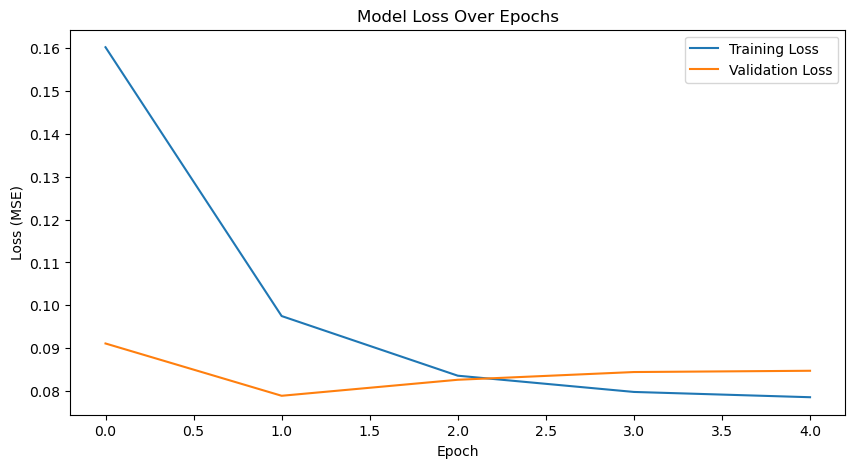

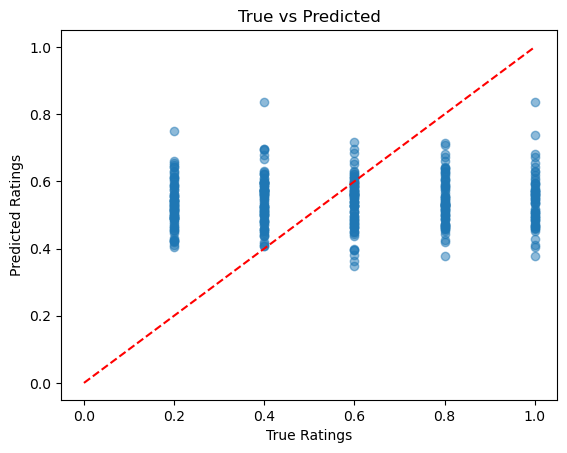

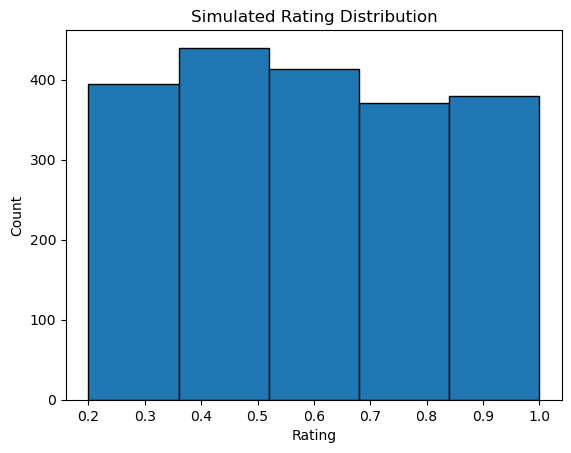

In [65]:
# visualizations

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

plt.scatter(val_ratings, predicted_ratings, alpha=0.5)
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("True vs Predicted")
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

plt.hist(ratings, bins=5, edgecolor="black")
plt.title("Simulated Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [95]:
import numpy as np

user_id = 5
all_song_ids = np.arange(num_songs)

# Ensure correct shape: (num_songs, 1)
user_input = np.full((num_songs, 1), user_id)
song_input = all_song_ids.reshape(-1, 1)
audio_input = song_features 

# Predict ratings for each song for this user
predicted_scores = model.predict([user_input, song_input, audio_input])

# Get top 5 recommended songs
top_indices = np.argsort(predicted_scores.flatten())[::-1][:5]
recommended_song_ids = all_song_ids[top_indices]
print(top_indices)

# show recommeded songs
def show_recommendations(song_ids, file_paths, genres=None):
    for idx in song_ids:
        print(f"Song ID: {idx}")
        print(f"Path: {file_paths[idx]}")
        if genres:
            print(f"Genre: {genres[idx]}")
        print("-" * 30)
        
show_recommendations([142, 90, 21, 9, 48], song_file_paths, song_genres)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[142  90  21   9  48]
Song ID: 142
Path: /Users/andresaccone/Downloads/Data/genres_original/pop/pop.00032.wav
Genre: pop
------------------------------
Song ID: 90
Path: /Users/andresaccone/Downloads/Data/genres_original/hiphop/hiphop.00030.wav
Genre: hiphop
------------------------------
Song ID: 21
Path: /Users/andresaccone/Downloads/Data/genres_original/classical/classical.00045.wav
Genre: classical
------------------------------
Song ID: 9
Path: /Users/andresaccone/Downloads/Data/genres_original/blues/blues.00092.wav
Genre: blues
------------------------------
Song ID: 48
Path: /Users/andresaccone/Downloads/Data/genres_original/country/country.00060.wav
Genre: country
------------------------------
